In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(12,8)})

## Задание:
```
Вы работаете продуктовым аналитиком в компании по доставке еды на дом. Сервис доступен как в приложении на 
iOS, так и на Android. Вы настроили фронтовую аналитику в AppMetrica, и в конце квартала маркетинг-менеджер 
попросил вас проанализировать поведение пользователей, а также оценить эффективность каналов их привлечения. Вы выгрузили данные из AppMetrica за период с 1 января по 31 марта 2020 только по пользователям, 
зарегистрированным позднее 1 января 2020.
Обратите внимание на следующее:
- В выгрузке только уникальные действия пользователей за каждый день;
- Можно миновать стадию установки приложения, если оно было установлено ранее;
- Можно миновать стадию регистрации, если пользователь был уже залогинен на момент сессии. Однако
незарегистрированные пользователи не могут оформить покупку.
```

In [2]:
# Загружем датафрейм.

dir_path = '~/data_files/'
df = pd.read_csv(dir_path + 'app_metrica_data.zip', encoding='utf8', sep=',', parse_dates=['date'], compression='zip')
df.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [3]:
# Взглянем на размер датафрейма.

df.shape

(2747968, 8)

In [4]:
# Определим типы датафрейма (все даты должны быть корректно преобразованы).

df.dtypes

date            datetime64[ns]
event                   object
purchase_sum           float64
os_name                 object
device_id                int64
gender                  object
city                    object
utm_source              object
dtype: object

In [5]:
df.date.describe(datetime_is_numeric=True)

count                          2747968
mean     2020-02-12 16:07:54.209889536
min                2020-01-01 00:00:00
25%                2020-01-20 00:00:00
50%                2020-02-12 00:00:00
75%                2020-03-06 00:00:00
max                2020-03-31 00:00:00
Name: date, dtype: object

In [6]:
# Определим есть ли в нашем датафрейме записи, не относящиеся ни к одному из доступных типов (NaN значения).

df.event.isna().sum()

0

Поскольку таких ошибочных значений в нашем датафрейме нет, можно приступать к разведывательному анализу.

In [7]:
df.event.value_counts()

app_start      748705
search         708639
choose_item    538669
tap_basket     377665
app_install    154597
purchase       141383
register        78310
Name: event, dtype: int64

In [8]:
# Посмотрим совпадает ли число покупок, посчитанное как число заполненных/ненулевых значений, с числом событий "purchase"

num_purchases = (~df.purchase_sum.isna()).sum()
num_purchases

141383

Действительно, число покупок в обоих случаях совпадает. Интересно также взглянуть на распределение сумм покупок.

In [9]:
df.purchase_sum.describe()

count    141383.000000
mean        709.116092
std        1289.458186
min          61.000000
25%         226.500000
50%         394.000000
75%         560.500000
max        7884.000000
Name: purchase_sum, dtype: float64

Text(0.5, 1.0, 'Распределение сумм покупок')

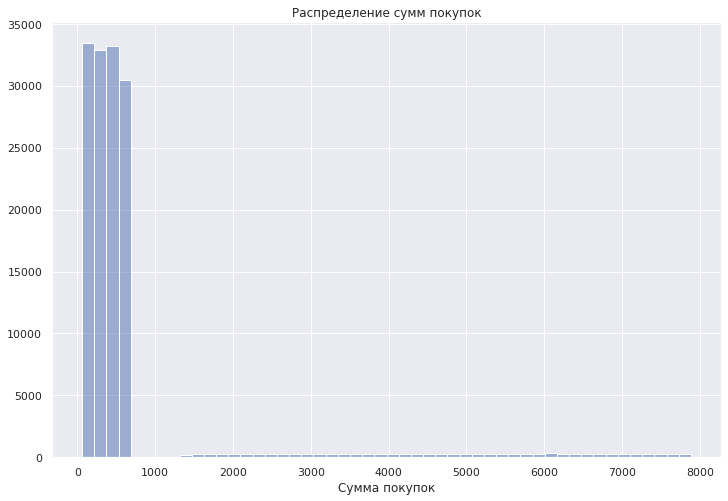

In [10]:
ax = sns.histplot(data=df, x='purchase_sum', bins=50, alpha=0.5, kde=False)
ax.set_xlabel('Сумма покупок')
ax.set_ylabel('')
ax.set_title('Распределение сумм покупок')

Как видно по гистограмме, мы имеем дело с очень скошенным распределением. Это не удивительно, поскольку большинство пользователей заказывают еду на относительно небольшую сумму, однако часть пользователей может сделать крупный заказ (к корпоративу или празднику). Попробуем использовать квантили, чтобы чуть подробнее рассмотреть данное распределение.

In [11]:
deciles = np.arange(0.1, 1.1, 0.1)
df.purchase_sum.quantile(q=deciles)

0.1     127.5
0.2     193.5
0.3     259.5
0.4     327.0
0.5     394.0
0.6     460.5
0.7     527.5
0.8     593.5
0.9     660.0
1.0    7884.0
Name: purchase_sum, dtype: float64

Выходит, что в 90% случаев стоимость заказа пользователя не превышает значения 660 денежных единиц.

Теперь создадим отдельную колонку с номером месяца для дальнейшего расчёта некоторых метрик (год всего лишь один, поэтому пару год-месяц сохранять не потребуется).

In [12]:
df['month'] = df.date.dt.month
df.month.value_counts()

1    1042407
2     874725
3     830836
Name: month, dtype: int64

In [13]:
month_names = {1: 'январь', 2: 'февраль', 3: 'март'}

In [14]:
# MAU за каждый из месяцев.

for i in range(3):
    mau = df[df['month'] == i+1].device_id.nunique()
    print('MAU за', month_names[i+1], '=', mau)

MAU за январь = 99161
MAU за февраль = 75032
MAU за март = 74623


In [15]:
# Число установок приложения за каждый из месяцев.

for i in range(3):
    installs_cnt = df.query(f'month == {i+1} & event == "app_install"').device_id.nunique()
    print('Число установок приложения за', month_names[i+1], '=', installs_cnt)

Число установок приложения за январь = 80297
Число установок приложения за февраль = 38078
Число установок приложения за март = 36222


Необходимо будет понять, из-за чего после января количество установок значительно сократилось (в двое).

In [16]:
# Среднее DAU за каждый из месяцев.

for i in range(3):
    temp = df[df['month'] == i+1].groupby('date', as_index=False).agg({'device_id' : 'nunique'})
    mean_dau = round(temp.device_id.mean(), 1)
    median_dau = temp.device_id.median().astype(int)
    print('Среднее DAU за', month_names[i+1], '= ' + str(mean_dau) + '; медианное DAU =', median_dau)

Среднее DAU за январь = 8662.3; медианное DAU = 8583
Среднее DAU за февраль = 8404.6; медианное DAU = 7830
Среднее DAU за март = 7631.1; медианное DAU = 7008


In [17]:
# Посмотрим на распределение источников трафика.

df.utm_source.value_counts()

-                610458
vk_ads           418456
yandex-direct    390232
instagram_ads    382891
google_ads       374257
facebook_ads     336953
referal          234721
Name: utm_source, dtype: int64

Text(0.5, 1.0, 'Распределение сессий по источнику трафика')

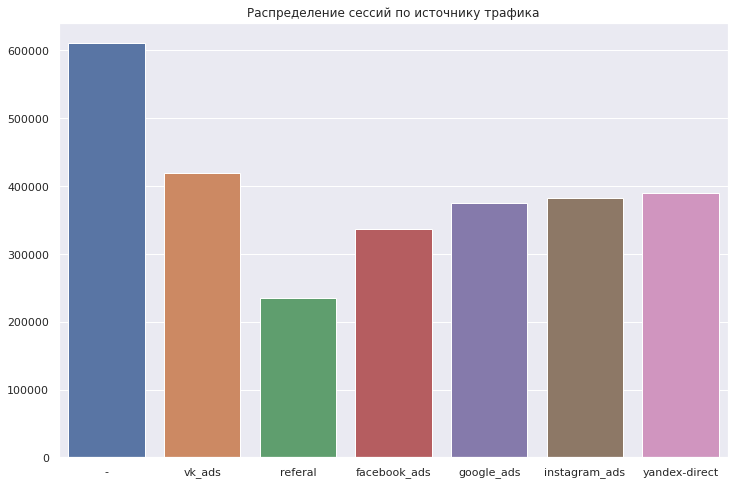

In [18]:
ax = sns.countplot(data=df, x=df.utm_source)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Распределение сессий по источнику трафика')

Как можно видеть по полученной диаграмме, источником трафика, генерирующим самое большое число сессий, является источник '-'.
Будем считать, что если стоит '-', то либо канал не определен, либо это скачивание приложения напрямую, либо это посещение не с рекламы (organic).

In [19]:
# Определим рекламный источник, который привёл в приложение наибольшее число уникальных новых пользователей.

utm_source_rank_df = df.groupby('utm_source', as_index=False) \
    .agg({'device_id' : 'nunique'}) \
    .rename(columns = {'device_id' : 'device_cnt'}) \
    .sort_values('device_cnt', ascending=False)
utm_source_rank_df

,utm_source,device_cnt
0,-,52273
6,yandex-direct,40712
2,google_ads,38096
5,vk_ads,34086
3,instagram_ads,31048
1,facebook_ads,25959
4,referal,15926


Text(0.5, 1.0, 'Распределение уникальных привлеченных пользователей по источнику трафика')

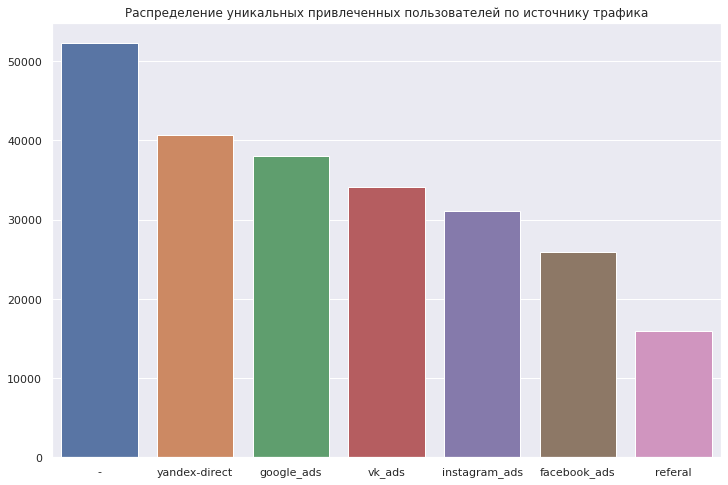

In [20]:
ax = sns.barplot(data=utm_source_rank_df, x='utm_source', y='device_cnt')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Распределение уникальных привлеченных пользователей по источнику трафика')

Не считая нерекламного (органика и нераспознанные) источника трафика, наибольшее число уникальных пользователей перешло в приложение через рекламу Яндекс Директ. Наименее успешен в привлечении новых пользователей реферальный маркетинг, однако в этом нет ничего удевительного. Также реклама Facebook является наименее эффективной в привлечении новых пользователей среди соцсетей.

Разобъём пользователей на когорты по дню установки приложения и посчитаем для них конверсию из установки в покупку в течение 7 дней. Считаем пользователя сконвертировавшимся, если с момента установки до совершения первой покупки прошло не более 7 дней.

In [21]:
# Отберём установивших приложение пользователей вместе с первой датой установки приложения.

installs = df.query('event == "app_install"')[['date', 'device_id']]

# Для вычисления самой первой даты установки приложения можно отсортировать датасет по пользователям и дате в порядке возрастания
# с последующим удалением всех повторяющихся пользователей, кроме самой первой записи о пользователе (с самой ранней датой установки).
installs = installs.sort_values(['device_id', 'date'], ascending=[True,True]).drop_duplicates('device_id')
installs = installs.rename(columns = {'date':'install_date'})
installs.head()

,install_date,device_id
2563772,2020-01-15,4013
2524313,2020-01-04,4016
2524855,2020-01-04,4046
2652384,2020-03-19,4065
2593631,2020-01-31,4067


In [22]:
# Мы используем inner join при объединении таблиц, поскольку хотим оставлять только пользователей, установивших приложение,
# причём сделавших это с 1 января 2020, поскольку у нас нет данных об установках до этой даты.

merged_df = df.merge(installs, on=['device_id'], how='inner')
merged_df.sort_values(['date', 'device_id']).head(20)

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month,install_date
160359,2020-01-01,app_start,NaN,ios,4378,male,Saint-Petersburg,google_ads,1,2020-01-01
160360,2020-01-01,choose_item,NaN,ios,4378,male,Saint-Petersburg,google_ads,1,2020-01-01
160361,2020-01-01,purchase,628.5,ios,4378,male,Saint-Petersburg,google_ads,1,2020-01-01
160362,2020-01-01,search,NaN,ios,4378,male,Saint-Petersburg,google_ads,1,2020-01-01
160363,2020-01-01,tap_basket,NaN,ios,4378,male,Saint-Petersburg,google_ads,1,2020-01-01
160382,2020-01-01,app_install,NaN,ios,4378,male,Saint-Petersburg,google_ads,1,2020-01-01
160383,2020-01-01,register,NaN,ios,4378,male,Saint-Petersburg,google_ads,1,2020-01-01
232950,2020-01-01,app_start,NaN,android,4505,female,Moscow,yandex-direct,1,2020-01-01
232951,2020-01-01,choose_item,NaN,android,4505,female,Moscow,yandex-direct,1,2020-01-01
232952,2020-01-01,purchase,72.0,android,4505,female,Moscow,yandex-direct,1,2020-01-01


In [23]:
len(merged_df)

2263023

Важно помнить, что в дальнейшем в каждом когортном анализе будут отсутствовать пользователи, которые установили приложение до 1 января 2020, поскольку для них нельзя рассчитать когорты.

In [24]:
# Подсчитаем количество дней, прошедших с момента первой установки приложения
# до каждого действия пользователя, зафиксированного в датасете.

merged_df['days_since_install'] = merged_df.date - merged_df.install_date
merged_df['days_since_install'].value_counts()

0 days     731956
1 days      69846
2 days      47397
3 days      39380
4 days      36184
            ...  
86 days      4606
87 days      3857
88 days      3251
89 days      2719
90 days      1559
Name: days_since_install, Length: 91, dtype: int64

По числу дней, прошедших с дня первой установки приложения, и количеству уникальных пользователей в этот день можно судить о метрике retention rate. Для этого надо будет провести отдельный когортный анализ. Однако прежде надо закончить с когортным по анализом конверсии из установки в покупку в течение 7 дней.

In [25]:
# Отфильтруем сделавших покупки пользователей вместе с датой самого первого заказа.

first_purchases = merged_df.query('event == "purchase"')[['date', 'device_id']]

# Для вычисления даты самого первого заказа можно отсортировать датасет по пользователям
# и дате в порядке возрастания с последующим удалением всех повторяющихся пользователей,
# кроме самой первой записи о пользователе (с самой ранней датой покупки).

first_purchases = first_purchases \
    .sort_values(['device_id', 'date'], ascending=[True,True]) \
    .drop_duplicates('device_id')
first_purchases = first_purchases.rename(columns = {'date':'first_purchase_date'})
first_purchases.head()

,first_purchase_date,device_id
535343,2020-01-04,4046
713002,2020-01-07,4120
728166,2020-01-07,4125
738392,2020-02-27,4202
1949012,2020-02-19,4234


In [26]:
# Объединим данные об установках и покупках пользователей.
# Всех пользователей можно разделить на когорты по дате установки приложения.

install_to_purchase = merged_df.merge(first_purchases, on='device_id', how='left')
install_to_purchase.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month,install_date,days_since_install,first_purchase_date
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,1,2020-01-01,0 days,2020-01-07
1,2020-01-01,search,NaN,android,669460,female,Moscow,-,1,2020-01-01,0 days,2020-01-07
2,2020-01-03,app_start,NaN,android,669460,female,Moscow,-,1,2020-01-01,2 days,2020-01-07
3,2020-01-03,choose_item,NaN,android,669460,female,Moscow,-,1,2020-01-01,2 days,2020-01-07
4,2020-01-03,search,NaN,android,669460,female,Moscow,-,1,2020-01-01,2 days,2020-01-07


In [27]:
install_to_purchase['days_from_install_to_purchase'] = \
    (install_to_purchase['first_purchase_date'] - install_to_purchase['install_date']).dt.days

In [28]:
install_to_purchase['days_from_install_to_purchase'].value_counts()

0.0     667967
1.0     133584
2.0      86462
3.0      75541
4.0      60900
         ...  
81.0       272
86.0       268
88.0        88
89.0        84
87.0        16
Name: days_from_install_to_purchase, Length: 90, dtype: int64

In [29]:
# Попробуем вывести информацию о днях между установкой и первой покупкой в разбивке по квантилям.

for i in range(10):
    q = (i+1)/10
    quant = round(install_to_purchase['days_from_install_to_purchase'].quantile(q))
    print(f'В {round(q*100)}% случаев число дней от установки до первой покупки не превышает {quant};')

В 10% случаев число дней от установки до первой покупки не превышает 0;
В 20% случаев число дней от установки до первой покупки не превышает 0;
В 30% случаев число дней от установки до первой покупки не превышает 0;
В 40% случаев число дней от установки до первой покупки не превышает 1;
В 50% случаев число дней от установки до первой покупки не превышает 2;
В 60% случаев число дней от установки до первой покупки не превышает 5;
В 70% случаев число дней от установки до первой покупки не превышает 9;
В 80% случаев число дней от установки до первой покупки не превышает 14;
В 90% случаев число дней от установки до первой покупки не превышает 26;
В 100% случаев число дней от установки до первой покупки не превышает 89;


Половина всех пользователей делают покупку либо в тот же день, когда устанавливают приложение, либо в течении 2 дней с момента установки.

In [30]:
# Создадим столбец, классифицирующий когорты по значению разности между датой установки приложения и датой первой покупки
# (1 - если конверсия из установки в покупку произошла в течение 7 дней,
# 0 - если конверсия из установки в покупку вообще не произошла или произошла позже 7 дней с момента установки).

install_to_purchase['install_to_purchase_flag'] = (install_to_purchase['days_from_install_to_purchase'] <= 7)*1
install_to_purchase.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month,install_date,days_since_install,first_purchase_date,days_from_install_to_purchase,install_to_purchase_flag
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,1,2020-01-01,0 days,2020-01-07,6.0,1
1,2020-01-01,search,NaN,android,669460,female,Moscow,-,1,2020-01-01,0 days,2020-01-07,6.0,1
2,2020-01-03,app_start,NaN,android,669460,female,Moscow,-,1,2020-01-01,2 days,2020-01-07,6.0,1
3,2020-01-03,choose_item,NaN,android,669460,female,Moscow,-,1,2020-01-01,2 days,2020-01-07,6.0,1
4,2020-01-03,search,NaN,android,669460,female,Moscow,-,1,2020-01-01,2 days,2020-01-07,6.0,1


In [31]:
install_to_purchase['install_to_purchase_flag'].value_counts(normalize=True)*100

1    51.83288
0    48.16712
Name: install_to_purchase_flag, dtype: float64

Половина наших пользователей (с учётом всех пользователей, даже не совершавших покупки) сконвертировались из установки в покупку в течение 7 дней.

In [32]:
# Рассчитаем конверсию из установки в покупку в течение 7 дней с момента установки приложения для каждой когорты.

grouped_install_to_purchase = install_to_purchase \
    .groupby(['install_date', 'device_id'], as_index=False) \
    .agg({'install_to_purchase_flag' : 'max'}) \
    .rename(columns = {'install_date':'cohort'}).copy()
grouped_install_to_purchase = grouped_install_to_purchase.groupby('cohort', as_index=False) \
    .agg({'device_id' : 'nunique', 'install_to_purchase_flag' : 'mean'}) \
    .rename(columns = {'device_id' : 'users_cnt', 'install_to_purchase_flag' : 'install_to_purchase_cr'}).copy()

In [33]:
# Округлим полученное значение конверсии из установки в покупку для каждой когорты
# и отсортируем по убыванию конверсии.

grouped_install_to_purchase['install_to_purchase_cr'] = \
    round(grouped_install_to_purchase['install_to_purchase_cr'], 3)
grouped_install_to_purchase.sort_values('install_to_purchase_cr', ascending=False)

,cohort,users_cnt,install_to_purchase_cr
0,2020-01-01,3579,0.393
8,2020-01-09,1424,0.392
14,2020-01-15,4310,0.383
13,2020-01-14,5173,0.381
1,2020-01-02,3144,0.377
...,...,...,...
77,2020-03-18,1171,0.201
88,2020-03-29,1117,0.200
81,2020-03-22,1261,0.199
87,2020-03-28,1091,0.192


Как видно по результирующей таблице, в когортах 1 января и 9 января самые высокие значения конверсии из установки в покупку в течение 7 дней с момента установки приложения.

In [34]:
# Отсортируем когорты по числу пользователей, чтобы понять, в какие дни было больше всего установок.

grouped_install_to_purchase.sort_values('users_cnt', ascending=False).query('users_cnt >= 2500')

,cohort,users_cnt,install_to_purchase_cr
9,2020-01-10,13106,0.317
65,2020-03-06,6358,0.127
13,2020-01-14,5173,0.381
12,2020-01-13,4571,0.375
10,2020-01-11,4523,0.336
14,2020-01-15,4310,0.383
44,2020-02-14,4188,0.234
0,2020-01-01,3579,0.393
15,2020-01-16,3306,0.368
1,2020-01-02,3144,0.377


Как видно по полученной таблице, в когортах января самые высокие показатели числа установок приложения. Аномально большие всплески числа установок наблюдаются 1 января (при самой высокой конверсии в покупку среди всех когорт), 6 марта (при самой низкой конверсии в покупку среди всех когорт) и 14 января (с крайне высокой конверсией в покупку среди всех когорт).

Интересно посмотреть, какой трафик привёл больше всего уникальных пользователей, имеющих конверсию из установки в покупку в течение 7 дней с момента установки приложения.

In [35]:
# Рассчитаем конверсию из установки в покупку в течение 7 дней с момента установки приложения
# в разрезе по источникам трафика.

install_to_purchase_by_source = install_to_purchase.groupby(['install_date', 'utm_source', 'device_id'], as_index=False) \
    .agg({'install_to_purchase_flag' : 'max'}) \
    .rename(columns = {'install_date':'cohort'}).copy()
install_to_purchase_by_source = install_to_purchase_by_source.groupby('utm_source', as_index=False) \
    .agg({'device_id' : 'nunique', 'install_to_purchase_flag' : 'mean'}) \
    .rename(columns = {'device_id' : 'users_cnt', 'install_to_purchase_flag' : 'install_to_purchase_cr'}).copy()
install_to_purchase_by_source['install_to_purchase_cr'] = round(install_to_purchase_by_source['install_to_purchase_cr'], 3)
install_to_purchase_by_source.sort_values('install_to_purchase_cr', ascending=False)

,utm_source,users_cnt,install_to_purchase_cr
4,referal,13216,0.355
1,facebook_ads,21018,0.350
5,vk_ads,29354,0.344
0,-,43240,0.336
3,instagram_ads,26313,0.334
2,google_ads,32926,0.330
6,yandex-direct,35618,0.325


Конверсия из установки в покупку для всех типов источников примерно одинаковая, но в качестве лидеров можно выделить канал реферального маркетинга и рекламу Facebook, однако у них и самое низкое количество привлечённых уникальных пользователей в абсолютном значении, что может означать, что для этих двух источников трафика можно попробовать закупить больше трафика с надеждой сохранить прежнее значение конверсии.

In [36]:
# Рассчитаем конверсию из установки в покупку в течение 7 дней с момента установки приложения
# в разрезе по ОС для каждой когорты.

install_to_purchase_by_os_and_cohort = install_to_purchase.groupby(['install_date', 'os_name', 'device_id'], as_index=False) \
    .agg({'install_to_purchase_flag' : 'max'}) \
    .rename(columns = {'install_date':'cohort'}).copy()
install_to_purchase_by_os_and_cohort = install_to_purchase_by_os_and_cohort.groupby(['cohort', 'os_name'], as_index=False) \
    .agg({'device_id' : 'nunique', 'install_to_purchase_flag' : 'mean'}) \
    .rename(columns = {'device_id' : 'users_cnt', 'install_to_purchase_flag' : 'install_to_purchase_cr'}).copy()
install_to_purchase_by_os_and_cohort['install_to_purchase_cr'] = round(install_to_purchase_by_os_and_cohort['install_to_purchase_cr'], 3)
install_to_purchase_by_os_and_cohort.sort_values(['install_to_purchase_cr', 'os_name'], ascending=[False, False])

,cohort,os_name,users_cnt,install_to_purchase_cr
16,2020-01-09,android,807,0.409
0,2020-01-01,android,2238,0.408
37,2020-01-19,ios,837,0.399
27,2020-01-14,ios,1870,0.396
28,2020-01-15,android,2744,0.391
...,...,...,...,...
175,2020-03-28,ios,503,0.185
178,2020-03-30,android,518,0.185
157,2020-03-19,ios,621,0.184
161,2020-03-21,ios,514,0.173


In [37]:
# Рассчитаем конверсию из установки в покупку в течение 7 дней с момента установки приложения
# в разрезе по каждому виду ОС.

install_to_purchase_by_os = install_to_purchase.groupby(['install_date', 'os_name', 'device_id'], as_index=False) \
    .agg({'install_to_purchase_flag' : 'max'}) \
    .rename(columns = {'install_date':'cohort'}).copy()
install_to_purchase_by_os = install_to_purchase_by_os.groupby('os_name', as_index=False) \
    .agg({'device_id' : 'nunique', 'install_to_purchase_flag' : 'mean'}) \
    .rename(columns = {'device_id' : 'users_cnt', 'install_to_purchase_flag' : 'install_to_purchase_cr'}).copy()
install_to_purchase_by_os['install_to_purchase_cr'] = round(install_to_purchase_by_os['install_to_purchase_cr'], 3)
install_to_purchase_by_os.sort_values('install_to_purchase_cr', ascending=False)

,os_name,users_cnt,install_to_purchase_cr
0,android,90578,0.315
1,ios,65412,0.287


В результате проведенного анализа конверсии в разрезе по ОС можно заметить, что на платформе Android средняя конверсия из установки в покупку выше, чем на iOS. Если же смотреть в разбивке и по когортам, и по типу ОС, то наиболее высокие значения конверсии из установки в покупку в когортах 1 и 9 января для платформы Android, а самые низкие - в когортах 6 и 21 марта для платформы iOS. Попробуем ещё взглянуть на среднемесячные значения конверсий в разрезе по типу ОС.

In [38]:
install_to_purchase_by_os_and_cohort['cohort_month'] = install_to_purchase_by_os_and_cohort.cohort.dt.month
install_to_purchase_by_os_and_cohort = install_to_purchase_by_os_and_cohort.groupby(['cohort_month', 'os_name'], as_index=False) \
    .agg({'install_to_purchase_cr' : 'mean'}) \
    .rename(columns = {'install_date':'cohort'}).copy()
install_to_purchase_by_os_and_cohort['install_to_purchase_cr'] = round(install_to_purchase_by_os_and_cohort['install_to_purchase_cr'], 3)
install_to_purchase_by_os_and_cohort.sort_values('install_to_purchase_cr', ascending=False)

,cohort_month,os_name,install_to_purchase_cr
0,1,android,0.351
1,1,ios,0.339
3,2,ios,0.305
2,2,android,0.298
4,3,android,0.248
5,3,ios,0.224


Судя по полученным результатам, с каждым месяцем средняя конверсия из установки в покупку уменьшалась для обеих ОС, что должно настораживать. Причём среднемесячная конверсия на платформе Android в января и марте выше, чем на платформе iOS, а в феврале - ниже, чем на платформе iOS. Однако эти помесячные отличия между ОС не настолько значимы, чтобы можно было решить, что приложение на какой-то из ОС гораздо хуже способствует конверсии пользователя в покупку. Куда большую значимость имеет изменение конверсии между месяцами. Похоже, что после января дела у приложения пошли хуже.

Теперь сгруппируем пользователей по месяцам, рассчитав для каждого месяца следующие метрики: DAU, конверсию из установки в добавление в блюда корзину, конверсию из установки в покупку.

In [39]:
# Создадим колонку, определяющую, добавлял ли пользователь блюда в корзину.
install_to_purchase['added_to_cart_flag'] = (install_to_purchase['event'] == 'choose_item')*1

# Получим датафрейм с конверсией в добавление в корзину с разбивкой по месяцам.
added_to_cart_per_month = install_to_purchase \
    .groupby(['month', 'device_id'], as_index=False) \
    .agg({'added_to_cart_flag' : 'max'}).copy() \
    .groupby('month', as_index=False) \
    .agg({'added_to_cart_flag' : 'mean'}) \
    .rename(columns = {'added_to_cart_flag' : 'added_to_cart_cr'})

# Получим датафрейм с конверсией в покупку с разбивкой по месяцам.
install_to_purchase_per_month = install_to_purchase \
    .groupby(['month', 'device_id'], as_index=False) \
    .agg({'install_to_purchase_flag' : 'max'}).copy() \
    .groupby('month', as_index=False) \
    .agg({'install_to_purchase_flag' : 'mean'}) \
    .rename(columns = {'install_to_purchase_flag' : 'install_to_purchase_cr'})

template_df = install_to_purchase.groupby('month', as_index=False) \
    .agg({'device_id' : 'nunique'}) \
    .rename(columns = {'device_id' : 'DAU'}) \
    .sort_values('month', ascending=True).copy()

# Получим итоговый датафрейм с нужными метриками конверсий.
template_df.merge(added_to_cart_per_month, on='month', how='left') \
    .merge(install_to_purchase_per_month, on='month', how='left')

,month,DAU,added_to_cart_cr,install_to_purchase_cr
0,1,80297,0.825299,0.347996
1,2,60697,0.823220,0.354532
2,3,60568,0.798342,0.304022


На основании полученных результатов конверсий можно заметить, что в марте у нас идёт заметное проседание конверсий, хотя для первых двух месяцев значения конверсий практически идентичны.

Теперь проведём когортный анализ для метрики retention rate. Сперва надо сократить количество когорт, взяв недели вместо дней.

In [40]:
# Создадим поле cohort, соответствующее дате установки приложения.
merged_df = merged_df \
    .rename(columns = {'install_date' : 'cohort'})

# Удалим пропуски в поле "days_since_install", поскольку эти значения
# будут мешать расчётам, но никак не помогут при дальнейшем анализе.
merged_df = merged_df.dropna(subset=['days_since_install'])

# А также добавим поле, отражающее число недель с момента установки приложения.
merged_df['weeks_since_install'] = merged_df['days_since_install'].dt.days // 7
merged_df.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month,cohort,days_since_install,weeks_since_install
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,1,2020-01-01,0 days,0
1,2020-01-01,search,NaN,android,669460,female,Moscow,-,1,2020-01-01,0 days,0
2,2020-01-03,app_start,NaN,android,669460,female,Moscow,-,1,2020-01-01,2 days,0
3,2020-01-03,choose_item,NaN,android,669460,female,Moscow,-,1,2020-01-01,2 days,0
4,2020-01-03,search,NaN,android,669460,female,Moscow,-,1,2020-01-01,2 days,0


In [41]:
# Cгруппируем данные по когорте и номеру недели с момента установки приложения,
# подсчитав количество уникальных пользователей.
df_cohort = merged_df.groupby(['cohort', 'weeks_since_install'], as_index=False) \
    .agg(n_customers=('device_id', 'nunique')) \
    .reset_index(drop=False) \
    .sort_values(['cohort', 'weeks_since_install'])

df_cohort.head()

,index,cohort,weeks_since_install,n_customers
0,0,2020-01-01,0,3579
1,1,2020-01-01,1,1895
2,2,2020-01-01,2,1690
3,3,2020-01-01,3,1606
4,4,2020-01-01,4,1513


In [42]:
# Построим сводную таблицу, где строками будут когорты, колонками - номера недели,
# а значениями - количество уникальных пользователей.
# Все пустые значения заполним нулями.

df_cohort = df_cohort \
    .rename(columns = {'weeks_since_install':'period_number'})

df_cohort['cohort'] = df_cohort['cohort'].dt.date


cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers') \
.fillna(0)

# Далее необходимо преобразовать абсолютные значения в относительные (процент удержания).
# В качестве размера когорты, на который будут делиться все соответствующие конкретной когорте столбцы,
# выступает значение в нулевом столбце (поэтому там все значения равны 100%).
cohort_size = cohort_pivot.iloc[:,0].copy()

# Чтобы значения были выражены в процентах необходимо умножить cohort_size на 1/100.
retention_matrix = cohort_pivot.divide(cohort_size * 0.01, axis = 0)
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2020-01-01,100.0,52.947751,47.219894,44.872870,42.274378,38.977368,39.675887,39.620006,34.953898,36.350936,33.584800,33.165689,32.662755
2020-01-02,100.0,49.872774,43.670483,43.479644,40.076336,37.468193,38.040712,37.086514,33.174300,34.828244,32.474555,32.220102,27.830789
2020-01-03,100.0,45.337219,40.008326,36.303081,33.347211,31.848460,31.806828,31.931724,27.518734,29.142381,26.644463,27.268943,20.982515
2020-01-04,100.0,41.015838,35.335882,33.260513,28.836701,28.727471,28.399782,26.433643,26.761333,25.395958,23.812125,23.265975,15.783725
2020-01-05,100.0,37.342908,32.615200,29.742669,26.630760,27.707959,26.989826,23.159785,25.972472,21.903052,21.424297,22.441652,11.789348
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-27,100.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-28,100.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-29,100.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Построим heatmap, чтобы посмотреть на данную метрику в разрезе имеющихся у нас когорт.

In [43]:
df_cohort.dtypes

index             int64
cohort           object
period_number     int64
n_customers       int64
dtype: object

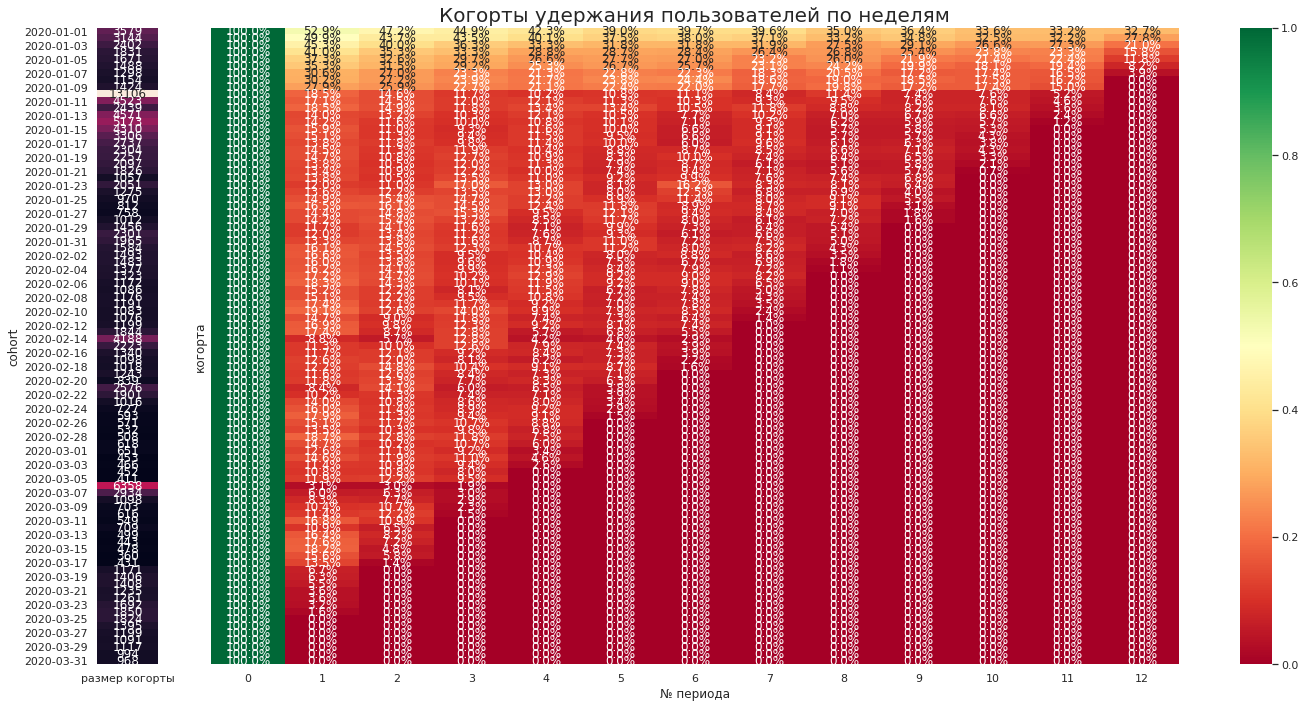

In [44]:
# Построим тепловую карту матрицы удержания.
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True, gridspec_kw={'width_ratios': [1, 20]})
    
    # матрица удержания
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                robust=False,
                fmt='.1%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Когорты удержания пользователей по неделям', fontsize=20)
    ax[1].set(xlabel='№ периода',
              ylabel='когорта')

    # размер когорты
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'размер когорты'})
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                ax=ax[0])

    fig.tight_layout()

На heatmap диаграмме можно видеть, что retention rate для когорт, установивших приложение после 9 января, начало активно проседать. Скорее всего новогодние каникулы повлияли на удержание пользователей (люди установили в новогодние праздники приложение, чтобы заказать еду на дом, однако даже после завершения праздников многие остались лояльными клиентами). Также стоит обратить внимание на то, что 6 марта был аномально большой всплеск числа установок, но на следующей неделе в приложении осталось только 3% пользователей. При этом именно этот день обладал самой низкой конверсией в покупку среди всех когорт. Из-за чего можно сделать вывод о том, что специалисты по маркетингу привлекли много некачественного трафика (пользователи установили приложение и сразу перестали им пользоваться).

Дополнительно можно посмотреть на распределение числа привлечённых 6 марта пользователей по источникам трафика.

In [45]:
merged_df[(merged_df['cohort'] == '2020-03-06')] \
    .groupby(['cohort', 'utm_source'], as_index=False) \
    .agg(customers_cnt=('device_id', 'nunique')) \
    .reset_index(drop=True) \
    .sort_values(['cohort', 'customers_cnt'], ascending=[True, False])

,cohort,utm_source,customers_cnt
0,2020-03-06,-,1480
6,2020-03-06,yandex-direct,1284
2,2020-03-06,google_ads,1108
5,2020-03-06,vk_ads,978
3,2020-03-06,instagram_ads,882
1,2020-03-06,facebook_ads,659
4,2020-03-06,referal,412


### Выводы:
1) retention rate пользователей, установивших приложение после 9 января, просело в связи с завершением новогодних каникул, однако многие клиенты, пришедшие в приложение за время новогодних каникул, остались постоянными клиентами;

2) с марта у пользователей стали проседать как значения конверсий в добавление в корзину и в первую покупку, так и значение retention rate;

3) в когортах 1 января и 9 января самые высокие значения конверсии из установки в покупку в течение 7 дней с момента установки приложения;

4) конверсия из установки в покупку у всех источников трафика примерно одинаковая, но в качестве лидеров можно выделить канал реферального маркетинга и рекламу Facebook, однако у них и самое низкое количество привлечённых уникальных пользователей в абсолютном значении, что может означать, что для этих двух источников трафика можно попробовать закупить больше трафика с надеждой сохранить прежнее значение конверсии;

5) на платформе Android средняя конверсия из установки в покупку выше, чем на iOS;

6) 6 марта специалисты по маркетингу привлекли много некачественного трафика (пользователи установили приложение и сразу перестали им пользоваться).